<a href="https://colab.research.google.com/github/Tharmika2002/Ride-Cancellation-Model-DataX/blob/main/Ride_Cancellation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataX — Ride Cancellation Prediction
**Notebook:** Ride-Cancellation-Model.ipynb   
**Author:** DataX Team

1. **Load data & audit (schema, missingness, class balance)**




In [ ]:
# === Setup ===
# !pip install pandas matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)


In [8]:
# === Paths / Config ===

PATH = '/content/drive/MyDrive/Colab Notebooks/Bengaluru Ola.csv'
TARGET_COL = "Booking Status"
RANDOM_STATE = 42


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# === Load CSV  ===

# Start with df = None, so we know if the file was successfully loaded later
df = None

# Try reading the file using different common encodings
# (sometimes CSVs are saved in utf-8, utf-8-sig, or latin-1 formats)
for enc in ["utf-8", "utf-8-sig", "latin-1"]:
    try:
        # Try to read the CSV with the current encoding
        df = pd.read_csv(PATH, encoding=enc)
        print(f"Successfully loaded with encoding: {enc}")
        break  # If it works, stop trying others
    except Exception as e:
        # If it fails, show the error and try the next encoding
        print(f"Failed with {enc}: {e}")

# Safety check: if df is still None, it means no encoding worked
assert df is not None, "Could not read CSV — check PATH or encoding."

# If we reach here, the dataset is successfully loaded
print("Loaded dataset.")
print("Shape (rows, columns):", df.shape)

# Show the first 5 rows as a quick preview
df.head(5)


Successfully loaded with encoding: utf-8
Loaded dataset.
Shape (rows, columns): (49999, 21)


,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled by Customer,Reason for Cancelling by Customer,Cancelled Rides by Driver,Reason for Cancelling by Driver,Incomplete Rides,Incomplete Rides Reason,Booking Value,Payment Method,Ride Distance,Driver Ratings,Customer Rating
0,28/01/2024,6:00:00,CNR1721175,Success,329258,Auto,Area-3,Area-2,5.42,18.46,0,NaN,0,NaN,0,NaN,868.06,Wallet,28.5,4.4,4.4
1,26/01/2024,3:00:00,CNR2871422,Cancelled by Driver,201414,Mini,Area-7,Area-6,NaN,NaN,0,NaN,1,The customer was coughing/sick,0,NaN,NaN,NaN,NaN,NaN,NaN
2,15/01/2024,16:00:00,CNR6875935,Cancelled by Driver,301629,Bike,Area-40,Area-24,NaN,NaN,0,NaN,1,Personal & Car related issues,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2/1/2024,22:00:00,CNR6798834,Cancelled by Driver,319684,Prime Sedan,Area-11,Area-24,NaN,NaN,0,NaN,1,The customer was coughing/sick,0,NaN,NaN,NaN,NaN,NaN,NaN
4,30/01/2024,22:00:00,CNR9661713,Incomplete,330283,Bike,Area-41,Area-45,NaN,NaN,0,NaN,0,NaN,1,Other Issue,NaN,NaN,NaN,NaN,NaN


In [11]:
# Print a quick summary of the dataframe
print("\n=== dtypes / info ===")
print(df.info())   # Shows number of rows, columns, dtypes, and non-null counts

# Build a custom schema summary DataFrame
schema = pd.DataFrame({
    # 1. Column names
    "column": df.columns,

    # 2. Data type of each column (converted to string for readability)
    "dtype": df.dtypes.astype(str).values,

    # 3. Number of unique values in each column (ignores NaN)
    "n_unique": [df[c].nunique(dropna=True) for c in df.columns],

    # 4. Number of missing values in each column
    "n_missing": df.isna().sum().values
})

# Sort the schema alphabetically by column name (optional, just for neatness)
schema = schema.sort_values("column")

# Display the schema summary
schema



=== dtypes / info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               49999 non-null  object 
 1   Time                               49999 non-null  object 
 2   Booking ID                         49999 non-null  object 
 3   Booking Status                     49999 non-null  object 
 4   Customer ID                        49999 non-null  int64  
 5   Vehicle Type                       49999 non-null  object 
 6   Pickup Location                    49999 non-null  object 
 7   Drop Location                      49999 non-null  object 
 8   Avg VTAT                           33484 non-null  float64
 9   Avg CTAT                           33484 non-null  float64
 10  Cancelled  by Customer             49999 non-null  int64  
 11  Reason for Cancelling by Custom

,column,dtype,n_unique,n_missing
9,Avg CTAT,float64,2901,16515
8,Avg VTAT,float64,1901,16515
2,Booking ID,object,49866,0
3,Booking Status,object,4,0
16,Booking Value,float64,30745,16515
10,Cancelled by Customer,int64,2,0
12,Cancelled Rides by Driver,int64,2,0
4,Customer ID,int64,48669,0
20,Customer Rating,float64,21,16515
0,Date,object,31,0


,missing,missing_%
Incomplete Rides Reason,46893,93.79
Reason for Cancelling by Customer,46200,92.40
Reason for Cancelling by Driver,40389,80.78
Avg VTAT,16515,33.03
Payment Method,16515,33.03
Customer Rating,16515,33.03
Ride Distance,16515,33.03
Avg CTAT,16515,33.03
Driver Ratings,16515,33.03
Booking Value,16515,33.03


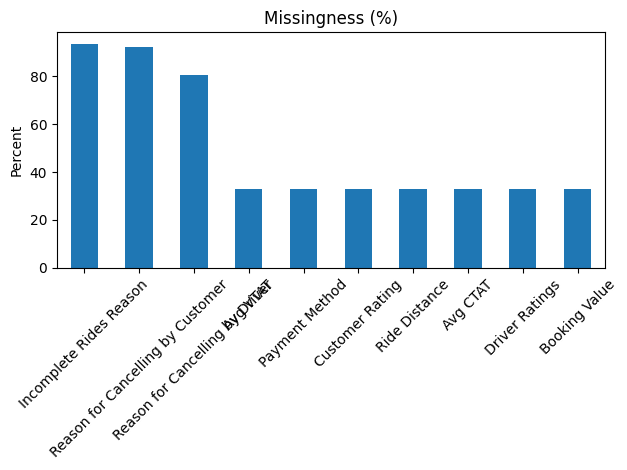

In [12]:
# === Missing Data Audit ===

# 1. Count missing values per column
# df.isna() → True/False for NaN
# .sum() → counts how many NaN in each column
# .sort_values(descending) → columns with most missing values come first
missing = df.isna().sum().sort_values(ascending=False)

# 2. Convert missing counts into percentages
# Divide by total rows, multiply by 100 → percentage
# .round(2) → keep 2 decimal places
missing_pct = (missing / len(df) * 100).round(2)

# 3. Create a summary DataFrame showing both counts and percentages
audit = pd.DataFrame({
    "missing": missing,       # raw count of NaN
    "missing_%": missing_pct  # percentage of NaN
})

# 4. Display the audit table in Colab/Jupyter
display(audit)

# === Optional: Quick visualization of missing data ===

# Only plot columns that actually have missing values (>0)
ax = (missing_pct[missing_pct > 0]).plot(
    kind="bar",               # bar chart
    title="Missingness (%)",  # chart title
    rot=45                    # rotate x-axis labels 45° for readability
)

# Add y-axis label
ax.set_ylabel("Percent")

# Adjust layout to avoid label overlap
plt.tight_layout()

# Show the chart
plt.show()


,class,count,percent
0,Success,33484,66.97
1,Cancelled by Driver,9610,19.22
2,Cancelled by Customer,3799,7.60
3,Incomplete,3106,6.21


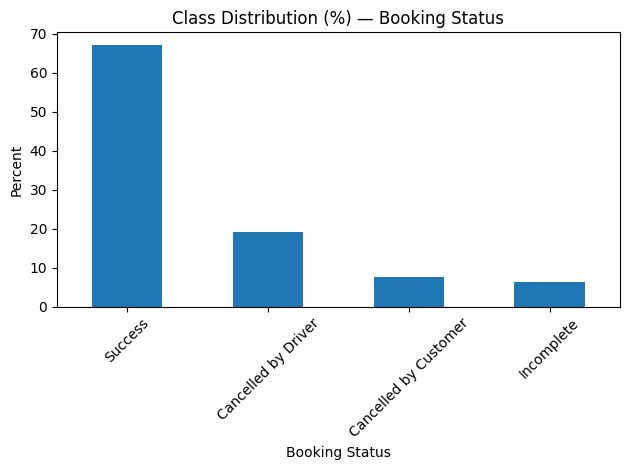

In [13]:
# === Class Distribution Audit ===

# 1. Safety check:
# Make sure the target column name exists in the dataset.
# If not, stop and show a helpful error message.
assert TARGET_COL in df.columns, f"TARGET_COL '{TARGET_COL}' not found. Check column name."

# 2. Count how many rows belong to each class (category of the target variable).
# Example: Success, Cancelled by Driver, Cancelled by Customer, Incomplete.
# dropna=False → includes NaN if any exist in the target column.
class_counts = df[TARGET_COL].value_counts(dropna=False)

# 3. Calculate the percentage of each class.
# normalize=True → gives proportions instead of raw counts.
# Multiply by 100 to convert to percentages.
# round(2) → keep only 2 decimal places for neat output.
class_percent = (df[TARGET_COL].value_counts(normalize=True, dropna=False) * 100).round(2)

# 4. Create a summary table combining both counts and percentages.
# pd.DataFrame → create a new dataframe with two columns.
# rename_axis("class") → name the index as 'class'.
# reset_index() → make 'class' a normal column instead of an index.
balance = (
    pd.DataFrame({
        "count": class_counts,    # number of samples in each class
        "percent": class_percent  # percentage of total samples
    })
    .rename_axis("class")        # set the index name as 'class'
    .reset_index()               # move 'class' into a column
)

# 5. Display the summary table in Jupyter/Colab.
# Shows class name, count, and percent for each class.
display(balance)

# 6. Plot a bar chart of class percentages.
# kind="bar" → vertical bar chart.
# title=... → add a dynamic title showing which column we’re analyzing.
# rot=45 → rotate x-axis labels by 45° for readability.
ax = class_percent.plot(
    kind="bar",
    title=f"Class Distribution (%) — {TARGET_COL}",
    rot=45
)

# Add label to the y-axis for clarity.
ax.set_ylabel("Percent")

# Adjust plot spacing so titles/labels don’t overlap.
plt.tight_layout()

# Show the final chart.
plt.show()


In [14]:
# === Preview Normalized Version of 'Booking Status' ===

# 1. Take the target column and convert all values to strings
#    (this ensures NaN or numeric values don’t cause errors when cleaning)
norm = df[TARGET_COL].astype(str)

# 2. Remove leading and trailing whitespace from each value
#    Example: " Success " → "Success"
norm = norm.str.strip()

# 3. Convert all text to lowercase
#    Example: "SUCCESS" → "success"
norm = norm.str.lower()

# 4. Count how many times each unique normalized value appears
#    This helps you see if there are messy duplicates (like "success" vs "succes")
value_counts = norm.value_counts()

# 5. Show the top 10 most common normalized values
#    Useful for quickly checking whether the labels are consistent
value_counts.head(10)


,count
Booking Status,
success,33484
cancelled by driver,9610
cancelled by customer,3799
incomplete,3106


2. **Define label (4 classes) & leakage check (booking-time-only features)**

In [15]:
# === Step 3: Define Label & Remove Leakage ===

# 1. Define the target column
TARGET_COL = "Booking Status"

# 2. Check unique values of the target column
print("Target Classes:")
print(df[TARGET_COL].value_counts())

# 3. Identify leakage columns
leakage_cols = ["Drop Time", "Trip Duration", "Cancel Reason"]

# Keep only booking-time-available features
df_clean = df.drop(columns=[c for c in leakage_cols if c in df.columns])

print("\nRemaining columns after leakage removal:")
print(df_clean.columns.tolist())


Target Classes:
Booking Status
Success                  33484
Cancelled by Driver       9610
Cancelled by Customer     3799
Incomplete                3106
Name: count, dtype: int64

Remaining columns after leakage removal:
['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID', 'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT', 'Avg CTAT', 'Cancelled  by Customer', 'Reason for Cancelling by Customer', 'Cancelled Rides by Driver', 'Reason for Cancelling by Driver', 'Incomplete Rides', 'Incomplete Rides Reason', 'Booking Value', 'Payment Method', 'Ride Distance', 'Driver Ratings', 'Customer Rating']


3. **Feature engineering**

In [16]:
# === Merge Date + Time into one datetime column ===

# Step 1: Combine Date and Time into a single string
# Example: "2023-05-15" + " " + "14:30:00" → "2023-05-15 14:30:00"
df["Booking Datetime"] = pd.to_datetime(
    df["Date"].astype(str) + " " + df["Time"].astype(str),
    format="%d/%m/%Y %H:%M:%S",   # adjust this if your Date/Time format is different
    errors="coerce"               # invalid rows become NaT instead of error
)

# Step 2: Extract features from the merged datetime
df["hour_of_day"] = df["Booking Datetime"].dt.hour
df["day_of_week"] = df["Booking Datetime"].dt.dayofweek   # Monday=0, Sunday=6
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

# Step 3: Create time bands
def assign_time_band(h):
    if pd.isna(h):
        return None
    if 5 <= h <= 11:
        return "Morning"
    elif 12 <= h <= 16:
        return "Afternoon"
    elif 17 <= h <= 21:
        return "Evening"
    else:
        return "Night"

df["time_band"] = df["hour_of_day"].apply(assign_time_band)

# Step 4: Preview the new columns
print(df[["Date", "Time", "Booking Datetime", "hour_of_day", "day_of_week", "is_weekend", "time_band"]].head(10))

         Date      Time    Booking Datetime  hour_of_day  day_of_week  is_weekend  time_band
0  28/01/2024   6:00:00 2024-01-28 06:00:00            6            6           1    Morning
1  26/01/2024   3:00:00 2024-01-26 03:00:00            3            4           0      Night
2  15/01/2024  16:00:00 2024-01-15 16:00:00           16            0           0  Afternoon
3    2/1/2024  22:00:00 2024-01-02 22:00:00           22            1           0      Night
4  30/01/2024  22:00:00 2024-01-30 22:00:00           22            1           0      Night
5  14/01/2024  20:00:00 2024-01-14 20:00:00           20            6           1    Evening
6  17/01/2024  21:00:00 2024-01-17 21:00:00           21            2           0    Evening
7  30/01/2024   0:00:00 2024-01-30 00:00:00            0            1           0      Night
8  22/01/2024   8:00:00 2024-01-22 08:00:00            8            0           0    Morning
9   11/1/2024   5:00:00 2024-01-11 05:00:00            5            3 

In [17]:
# --- Location Features ---

# Pickup & Drop zones are already categorical (Area-1 … Area-50)
# Ensure they are treated as categories
df["Pickup Location"] = df["Pickup Location"].astype("category")
df["Drop Location"]   = df["Drop Location"].astype("category")

# Compute cancellation rate per Pickup Zone
pickup_cancel_rate = (
    df.groupby("Pickup Location")["Booking Status"]
    .apply(lambda x: (x != "Success").mean())   # fraction of non-success = cancellation rate
)
df["pickup_cancel_rate"] = df["Pickup Location"].map(pickup_cancel_rate)

# Compute cancellation rate per Drop Zone
drop_cancel_rate = (
    df.groupby("Drop Location")["Booking Status"]
    .apply(lambda x: (x != "Success").mean())
)
df["drop_cancel_rate"] = df["Drop Location"].map(drop_cancel_rate)

# Frequency of pickup-drop pairs (proxy for trip "distance"/commonness)
pair_freq = df.groupby(["Pickup Location", "Drop Location"]).size()
df["pickup_drop_pair_freq"] = list(zip(df["Pickup Location"], df["Drop Location"]))
df["pickup_drop_pair_freq"] = df["pickup_drop_pair_freq"].map(pair_freq)

/tmp/ipython-input-1206190329.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Pickup Location")["Booking Status"]
/tmp/ipython-input-1206190329.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Drop Location")["Booking Status"]
/tmp/ipython-input-1206190329.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pair_freq = df.groupby(["Pickup Location", "Drop Location"]).size()


In [18]:
# --- Ride & Payment Details ---

# Vehicle Type (categorical → will be one-hot encoded later in preprocessing)
df["vehicle_type"] = df["Vehicle Type"].astype("category")

# Payment Method → simplify to Cash vs Card
df["payment_method"] = df["Payment Method"].apply(
    lambda x: "Cash" if str(x).lower().strip() == "cash" else "Card"
)

# Package Type (if present in dataset)
if "Package Type" in df.columns:
    df["package_type"] = df["Package Type"].astype("category")

# Customer & Driver ratings → numeric, fill missing with median, scale later
if "Customer Rating" in df.columns:
    df["customer_rating"] = pd.to_numeric(df["Customer Rating"], errors="coerce")
    df["customer_rating"] = df["customer_rating"].fillna(df["customer_rating"].median())

if "Driver Rating" in df.columns:
    df["driver_rating"] = pd.to_numeric(df["Driver Rating"], errors="coerce")
    df["driver_rating"] = df["driver_rating"].fillna(df["driver_rating"].median())


**4. Preprocessing pipeline (impute, encode, scale)**

In [19]:
# === Step 5: Preprocessing pipeline (impute, encode, scale) ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import joblib

# --- 0) Config ---
TARGET_COL = "Booking Status"
RANDOM_STATE = 42
TEST_SIZE = 0.2

# --- 1) Define feature sets based on columns that actually exist ---
# Numeric features engineered in Step 4
numeric_candidates = [
    "hour_of_day", "day_of_week", "is_weekend",
    "pickup_cancel_rate", "drop_cancel_rate", "pickup_drop_pair_freq",
    "customer_rating", "driver_rating"
]
num_features = [c for c in numeric_candidates if c in df.columns]

# Categorical features engineered in Step 4
categorical_candidates = [
    "time_band",            # Morning/Afternoon/Evening/Night
    "Pickup Location",      # Area-*
    "Drop Location",        # Area-*
    "vehicle_type",         # Auto/Mini/Sedan/Bike...
    "payment_method",       # Cash/Card
    "package_type"          # optional
]
cat_features = [c for c in categorical_candidates if c in df.columns]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

# --- 2) Build X, y ---
# Keep only the columns we plan to use
X = df[num_features + cat_features].copy()
y = df[TARGET_COL].astype("category")

# --- 3) Train/Validation split (stratified) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, " Val shape:", X_val.shape)
print("Class distribution (train):")
print(y_train.value_counts(normalize=True).round(3))

# --- 4) Define preprocessing sub-pipelines ---
# Numeric: median impute + standardize
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: most-frequent impute + one-hot
# min_frequency=0.01 groups very-rare levels to keep matrix compact (set/adjust as needed)
ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=0.01)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", ohe)
])

# --- 5) ColumnTransformer that applies both ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features),
    ],
    remainder="drop"  # keep only specified columns
)

# --- 6) Fit preprocessor on training data; transform train/val ---
preprocessor.fit(X_train)

X_train_proc = preprocessor.transform(X_train)
X_val_proc   = preprocessor.transform(X_val)

print("Processed shapes → Train:", X_train_proc.shape, " Val:", X_val_proc.shape)

# (Optional) Inspect final feature names (great for debugging/report)
feature_names = preprocessor.get_feature_names_out()
print("Total processed features:", len(feature_names))
print(feature_names[:25], "...")  # preview

# --- 7) Persist preprocessor for reuse (models/ folder) ---
import os
os.makedirs("models", exist_ok=True)
joblib.dump(preprocessor, "models/preprocessor.pkl")
print("✅ Saved preprocessor to models/preprocessor.pkl")

Numeric features: ['hour_of_day', 'day_of_week', 'is_weekend', 'pickup_cancel_rate', 'drop_cancel_rate', 'pickup_drop_pair_freq', 'customer_rating']
Categorical features: ['time_band', 'Pickup Location', 'Drop Location', 'vehicle_type', 'payment_method']
Train shape: (39999, 12)  Val shape: (10000, 12)
Class distribution (train):
Booking Status
Success                  0.670
Cancelled by Driver      0.192
Cancelled by Customer    0.076
Incomplete               0.062
Name: proportion, dtype: float64
Processed shapes → Train: (39999, 120)  Val: (10000, 120)
Total processed features: 120
['num__hour_of_day' 'num__day_of_week' 'num__is_weekend'
 'num__pickup_cancel_rate' 'num__drop_cancel_rate'
 'num__pickup_drop_pair_freq' 'num__customer_rating'
 'cat__time_band_Afternoon' 'cat__time_band_Evening'
 'cat__time_band_Morning' 'cat__time_band_Night'
 'cat__Pickup Location_Area-1' 'cat__Pickup Location_Area-10'
 'cat__Pickup Location_Area-11' 'cat__Pickup Location_Area-12'
 'cat__Pickup Locati

6. **Handle class imbalance**


=== Decision Tree Results ===
                       precision    recall  f1-score   support

Cancelled by Customer       0.14      0.01      0.02       760
  Cancelled by Driver       0.54      0.98      0.69      1922
           Incomplete       0.21      0.01      0.02       621
              Success       1.00      0.96      0.98      6697

             accuracy                           0.83     10000
            macro avg       0.47      0.49      0.43     10000
         weighted avg       0.80      0.83      0.79     10000

Macro-F1: 0.42744780264176524


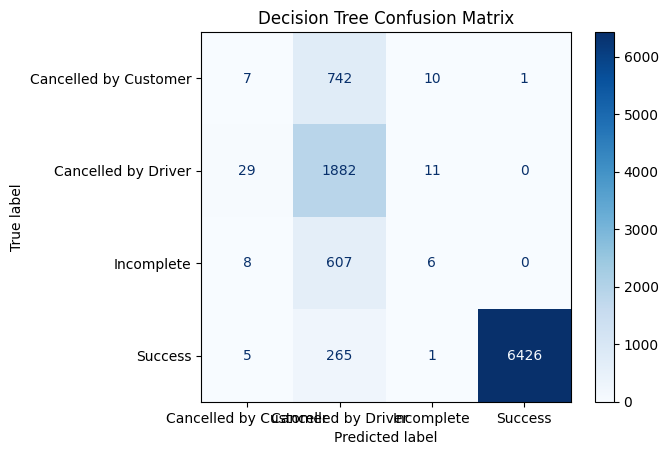

✅ Model saved as decision_tree.pkl


In [20]:
  # === Decision Tree Model ===
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Build pipeline: preprocessor + decision tree
dt_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(
        random_state=42,
        max_depth=10,         # limit depth to avoid overfitting (optional)
        min_samples_split=5   # minimum samples for split (optional)
    ))
])

# Train the model
dt_model.fit(X_train, y_train)

# Predictions on validation set
y_pred = dt_model.predict(X_val)

# Evaluation
print("\n=== Decision Tree Results ===")
print(classification_report(y_val, y_pred))
print("Macro-F1:", f1_score(y_val, y_pred, average="macro"))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.show()

# Save the trained model
joblib.dump(dt_model, "decision_tree.pkl")
print("✅ Model saved as decision_tree.pkl")

# (Optional) Download the model from Colab
# from google.colab import files
# files.download("decision_tree.pkl")


In [21]:
from google.colab import files
files.download("decision_tree.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
files.download("models/preprocessor.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>